---
# **Road Image Segmentation on the KITTI Road Dataset**
---

**Imports**

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import models
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, jaccard_score, precision_score, recall_score, roc_auc_score

**Directories**

In [2]:
img_path = '/DML/Datasets/KITTI_ROAD/training/image_2/'
mask_path = '/DML/Datasets/KITTI_ROAD/training/gt_image_2/'

**Pre-processing**

    1) We are splitting the input images into three sets: Training Data (70%), Validation Data (15%) and Test Data (15%).
    2) Create a function to Load, Sort, Resize, and Convert Images into a Numpy Array
    3) Create a function to view/display images and masks
    4) Create a function to convert the true mask into a binary mask (Road == 1; Non-road == 0)
    5) Convert the binary mask to grayscale and normalize it
    

Number of Training Images: 202
Number of Validation Images: 43
Number of Testing Images: 44
['um_000000.png', 'um_000001.png', 'um_000002.png', 'um_000003.png', 'um_000004.png', 'um_000005.png', 'um_000006.png', 'um_000007.png', 'um_000008.png', 'um_000009.png', 'um_000010.png', 'um_000011.png', 'um_000012.png', 'um_000013.png', 'um_000014.png', 'um_000015.png', 'um_000016.png', 'um_000017.png', 'um_000018.png', 'um_000019.png', 'um_000020.png', 'um_000021.png', 'um_000022.png', 'um_000023.png', 'um_000024.png', 'um_000025.png', 'um_000026.png', 'um_000027.png', 'um_000028.png', 'um_000029.png', 'um_000030.png', 'um_000031.png', 'um_000032.png', 'um_000033.png', 'um_000034.png', 'um_000035.png', 'um_000036.png', 'um_000037.png', 'um_000038.png', 'um_000039.png', 'um_000040.png', 'um_000041.png', 'um_000042.png', 'um_000043.png', 'um_000044.png', 'um_000045.png', 'um_000046.png', 'um_000047.png', 'um_000048.png', 'um_000049.png', 'um_000050.png', 'um_000051.png', 'um_000052.png', 'um_00

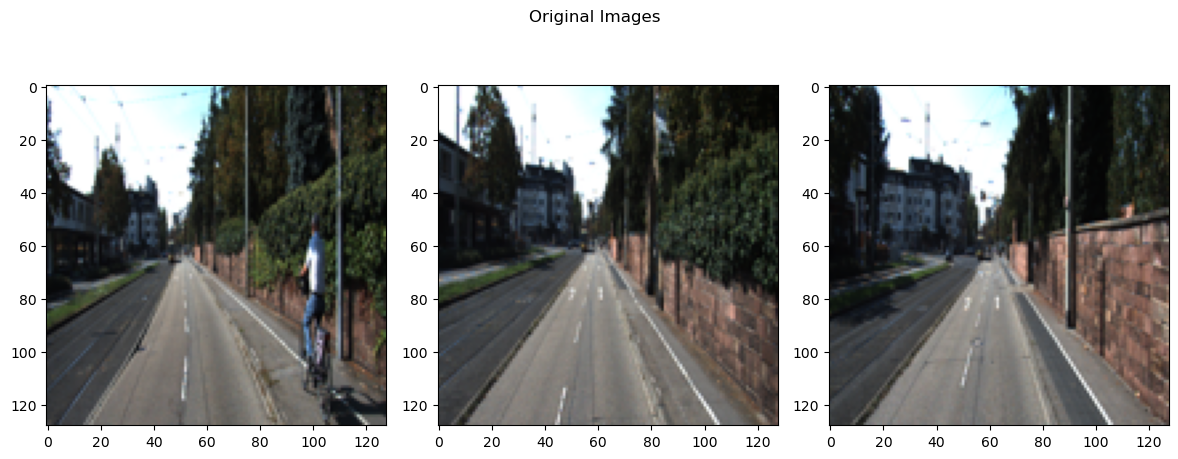

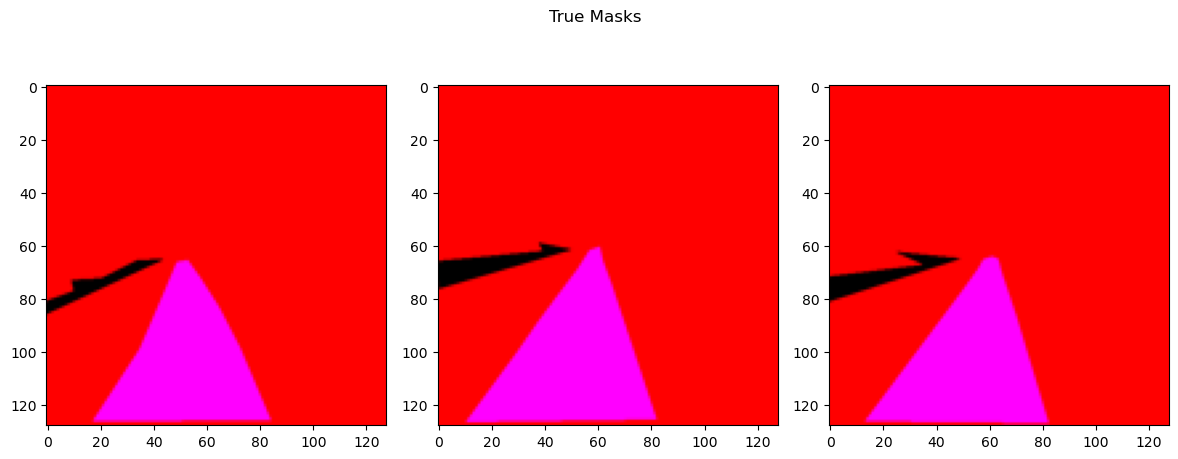

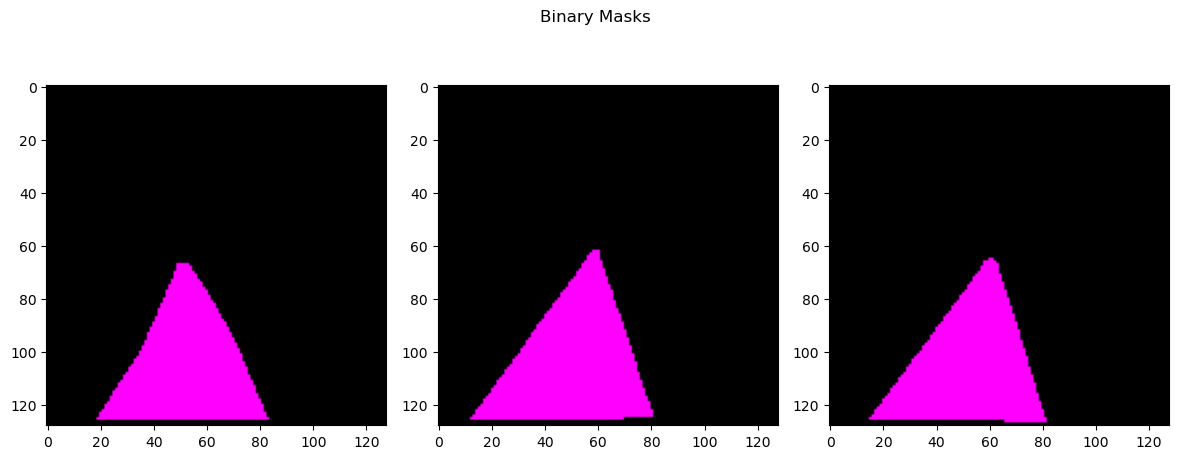

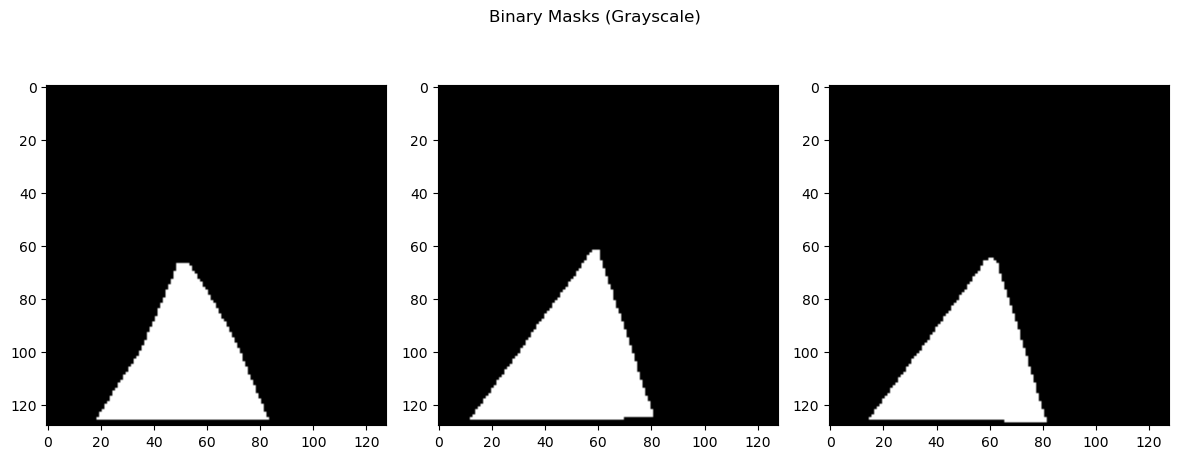

In [3]:
# Manual Train/Val/Test Split
train_size = int(len(os.listdir(img_path)) * 0.70)
val_size = int(len(os.listdir(img_path)) * 0.15)
test_size = int(len(os.listdir(img_path)) - train_size - val_size)
img_size = (128, 128) # For UNet Model
# img_size = (224, 224) # For Modified VGG Model

# Printing respective sizes
print(f"Number of Training Images: {train_size}")
print(f"Number of Validation Images: {val_size}")
print(f"Number of Testing Images: {test_size}")

# Load, Sort, Resize Images into a Numpy Array
def ProcessImages(path, mask=False):
    result = [] 
    images = os.listdir(path)
    if mask == True:
        images = [entry for entry in images if "road" in entry]
    images=sorted(images)
    print(images)
    for image in images:
        im = Image.open(os.path.join(path, image))
        resized_image = im.resize(img_size)
        res = np.asarray(resized_image)
        result.append(res)
    return np.array(result)

# Display the Images
def DisplayImages(images, disp_count, title, is_mask=False, is_grayscale=False):
    fig = plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    for i in range(1, disp_count+1):
        fig.add_subplot(1, disp_count, i)
        img = images[i-1, :]
        cmap = 'gray' if is_mask or is_grayscale else None
        plt.tight_layout()
        plt.imshow(img, cmap=cmap)

# Convert the Images and Masks into Numpy Arrays
true_images = ProcessImages(img_path, mask=False)
true_masks = ProcessImages(mask_path, mask=True)

# Display the Images and its respective Masks
DisplayImages(true_images, 3, 'Original Images')
DisplayImages(true_masks, 3, 'True Masks')

# Convert the true mask into a binary mask (Road == 1; Non-road == 0)
def encode_binary(true_masks):
    for i in range(len(true_masks)):
        road_label = np.array([255, 0, 255])
        binary_mask = np.all(true_masks[i] == road_label, axis = 2)
        true_masks[i] = true_masks[i] * binary_mask[..., np.newaxis]

# Display the respective Binary Encoded Masks 
encode_binary(true_masks)
DisplayImages(true_masks, 3, 'Binary Masks', is_mask=True)

# Grayscale Binary Masks
true_masks = np.dot(true_masks[..., :3], [0.2989, 0.5870, 0.1140]) 
true_masks = np.expand_dims(true_masks, axis=-1)
DisplayImages(true_masks, 3, 'Binary Masks (Grayscale)', is_grayscale=True)

# Normalize the Grayscale Binary Masks
true_masks[true_masks != 0.0] = 1.0
true_images  = true_images / 255.0

# Verify the shape
print(f"Shape of the Image: {true_images.shape}")
print(f"Shape of the Label/Mask: {true_masks.shape}")
true_images = true_images.astype(np.float32)
true_masks = true_masks.astype(np.float32)

**Splitting the Data**

In [4]:
# Testing Dataset
X_test = true_images[:test_size].transpose((0, 3, 1, 2))
Y_test = true_masks[:test_size].transpose((0, 3, 1, 2))

# Training and Validation Dataset
true_images = true_images[test_size:]
true_masks = true_masks[test_size:]
idx = np.random.permutation(len(true_images))  # Shuffle = True
shuffled_images = true_images[idx]
shuffled_masks = true_masks[idx]

# Train/Val Split
X_train=shuffled_images[:train_size].transpose((0, 3, 1, 2))
Y_train=shuffled_masks[:train_size].transpose((0, 3, 1, 2))
X_val=shuffled_images[train_size:train_size+val_size].transpose((0, 3, 1, 2))
Y_val=shuffled_masks[train_size:train_size+val_size].transpose((0, 3, 1, 2))

# Printing the shape of the Datasets
print(f'Training Dataset Shape: {X_train.shape}')
print(f'Validation Dataset Shape: {X_val.shape}')
print(f'Testing Dataset Shape: {X_test.shape}')

Training Dataset Shape: (202, 3, 128, 128)
Validation Dataset Shape: (43, 3, 128, 128)
Testing Dataset Shape: (44, 3, 128, 128)


**Dataset Class**

In [5]:
class SegmentDataset(Dataset):
    def __init__(self, imgs,mask):
        self.imgs = imgs
        self.mask = mask

    def __len__(self):
        return len(self.imgs)

    def get_batch_imgs(self, idx):
        return self.imgs[idx]
    
    def get_batch_masks(self, idx):
        return self.mask[idx]
    
    def __getitem__(self, index):
        imgs = self.get_batch_imgs(index)
        masks = self.get_batch_masks(index)
        return imgs,masks

**Data Loading**

In [6]:
# Datasets
train_dataset = SegmentDataset(X_train, Y_train)
val_dataset = SegmentDataset(X_val, Y_val)
test_dataset = SegmentDataset(X_test, Y_test)

# Initialize Parameters
batch_size = 16

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**UNet Model**

In [7]:
# NOTE: Architecture was derived from Andrew Ng's Deep Learning Lecture
# Double Convolution Class
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__()
        self.dconv = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.dconv(x)
    
# Our UNet Model Class 
in_features = 3
out_features = 1

class UNET(nn.Module):
    def __init__(self, in_channels=in_features, out_channels=out_features, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) # Upsampling
            self.ups.append(DoubleConv(feature*2, feature))

        self.left_over = DoubleConv(features[-1], features[-1]*2) # last part which starts the UP phase
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) # output segmentation  map

    def forward(self,x):
        skip_connections = []
        
        # Start Down Phase
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x) 
            x=self.pool(x)
        
        # Pass through (Left-to-Right))
        x=self.left_over(x)
        skip_connections=skip_connections[::-1]

        # Feeding to transposed conv (add skipped connection - 2 steps)
        for idx in range(0,len(self.ups), 2): 
            
            sc=skip_connections[idx//2]
            x=self.ups[idx](x)
            
            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1)  
            x = self.ups[idx+1](concat_skip) 

        return self.final_conv(x)   # No sigmoid here; return logits directly
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
print(f"Network Architecture Used:\n {UNET()}")

Device: cpu
Network Architecture Used:
 UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256,

**VGGNet Model**

In [8]:
# # Define FCN network using VGG-16 as backbone
# class Modified_VGG(nn.Module):
#     def __init__(self, num_classes):
#         super(Modified_VGG, self).__init__()
#         # vgg = models.vgg16(pretrained=True)
#         vgg = models.vgg16()
#         vgg.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))
#         self.features = vgg.features
        
#         # Decoder
#         self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=8, stride=8)
        
#         # Final segmentation layer
#         self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

#     def forward(self, x):
#         x = self.features(x)
        
#         # Upsampling path
#         x = self.upconv1(x)
#         x = self.upconv2(x)
#         x = self.upconv3(x)
        
#         return self.classifier(x)   # No activation (e.g., sigmoid) here since we will use BCEWithLogitsLoss
    
class Modified_VGG(nn.Module):
    def __init__(self):
        super(Modified_VGG, self).__init__()
        
        # Load pretrained VGG16 and extract the convolutional layers (encoder)
        vgg16 = models.vgg16()
        vgg16.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))
        self.encoder = vgg16.features
        
        # Define decoder layers (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upconv 1 (from 32x32 -> 64x64)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upconv 2 (from 64x64 -> 128x128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # Upconv 3 (from 128x128 -> 256x256)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),                        # Final output (binary map)
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=True)  # Resize to 512x512
        )
    
    def forward(self, x):
        # Encode using VGG16 (backbone)
        x = self.encoder(x)
        
        # Decode to produce segmentation map
        x = self.decoder(x)
        
        # No activation (e.g., sigmoid) here since we will use BCEWithLogitsLoss
        return x
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
print(f"Network Architecture Used:\n {Modified_VGG()}")

Device: cpu
Network Architecture Used:
 Modified_VGG(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2

**Initialize the Evaluation Metrics**

In [9]:
f1_metric = torchmetrics.F1Score(task="binary", num_classes=1, threshold=0.5).to(DEVICE)
iou_metric = torchmetrics.JaccardIndex(num_classes=1, task="binary").to(DEVICE)
accuracy_metric = torchmetrics.Accuracy(task="binary", threshold=0.5).to(DEVICE)

**Loss Calculation based on IoU Metric**

In [10]:
# class IoU_Loss(nn.Module):
#     def __init__(self, smooth=1e-6):
#         super(IoU_Loss, self).__init__()
#         self.smooth = smooth

#     def forward(self, pred, target):
#         pred = torch.sigmoid(pred)
#         intersection = (pred * target).sum(dim=(2, 3))
#         union = (pred + target).sum(dim=(2, 3)) - intersection

#         # Calculate IoU Score and IoU Loss
#         iou = (intersection + self.smooth) / (union + self.smooth)
#         mIoU = iou.mean()    # IoU Score
#         iou_loss = 1 - mIoU  # IoU Loss

#         return iou_loss

**Calculating weights for classes (based on the training masks)**

In [11]:
# # Function to calculate the class weights based on pixel distribution
# def calculate_class_weights(train_dataset):
#     total_pixels = 0
#     foreground_pixels = 0

#     for _, train_mask in train_dataset:
#         # Convert numpy array to torch tensor if it's not already a tensor
#         train_mask = torch.tensor(train_mask) if isinstance(train_mask, np.ndarray) else train_mask

#         total_pixels += train_mask.numel()
#         foreground_pixels += (train_mask == 1).sum().item()

#     background_pixels = total_pixels - foreground_pixels

#     # Class weights: inverse of frequency
#     weight_foreground = total_pixels / (2 * foreground_pixels)
#     weight_background = total_pixels / (2 * background_pixels)

#     return torch.tensor([weight_background, weight_foreground], dtype=torch.float32)

# class_weights = calculate_class_weights(train_dataset).to(DEVICE)
# print(f"Class Weights: Non-Road: {class_weights[0]}, Road: {class_weights[1]}")


# # Function to calculate the class weights based on pixel distribution
# def calculate_class_weights(mask_dataloader): 
#     total_pixels = 0
#     road_pixels = 0

#     for _, mask in mask_dataloader:
#         total_pixels += mask.numel()  # Total number of pixels in the dataset
#         road_pixels += (mask == 1).sum().item()  # Count of "road" pixels (value 1)

#     non_road_pixels = total_pixels - road_pixels  # Count of "non-road" pixels (value 0)

#     # Calculate weights inversely proportional to class frequency
#     road_weight = non_road_pixels / total_pixels
#     non_road_weight = road_pixels / total_pixels

#     return torch.tensor([non_road_weight, road_weight]).to(DEVICE)

# # Calculate weights using the training data
# class_weights = calculate_class_weights(train_dataloader)
# print(f"Class Weights: Non-Road: {class_weights[0]}, Road: {class_weights[1]}")


**Dice Coefficient Function**

In [12]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    # Intersection over all pixels
    intersection = (pred * target).sum(dim=2).sum(dim=2)  
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

**Training and Validation Loop**

In [13]:
# Training Loop
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    dice_scores = []
    accuracies = []

    # Initialize accuracy_metric for training
    train_accuracy_metric = torchmetrics.Accuracy(task="binary", threshold=0.5).to(device)

    for train_input, train_mask in data_loader:
        train_mask = train_mask.to(device)
        train_input = train_input.to(device)
        
        # Forward pass
        outputs = model(train_input.float())

        # Compute loss without applying sigmoid
        loss = loss_fn(outputs, train_mask.float())   # outputs are typically a torch.FloatTensor
        losses.append(loss.item())

        # Back-prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate Dice score and train accuracy using sigmoid applied to outputs
        outputs = torch.sigmoid(outputs)
        dice = dice_coefficient(outputs, train_mask)
        dice_scores.append(dice.item())
        accuracy = train_accuracy_metric(outputs, train_mask).item()
        accuracies.append(accuracy)

    return np.mean(losses), np.mean(dice_scores), np.mean(accuracies)

# Validation Loop
def validate_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    dice_scores = []
    f1_scores = []
    iou_scores = []
    accuracies = []

    with torch.no_grad():
        for val_input, val_mask in data_loader:
            val_input = val_input.to(device)
            val_mask = val_mask.to(device)
            
            # Forward pass
            outputs = model(val_input.float())

            # Compute loss without applying sigmoid
            loss = loss_fn(outputs, val_mask.float())   # outputs are typically a torch.FloatTensor
            losses.append(loss.item())

            # Calculate Dice score using sigmoid applied to outputs
            outputs = torch.sigmoid(outputs)
            dice = dice_coefficient(outputs, val_mask)
            dice_scores.append(dice.item())

            # Compute IoU, F1-Score, and Accuracy using torchmetrics
            f1 = f1_metric(outputs, val_mask).item()
            iou = iou_metric(outputs, val_mask).item()
            accuracy = accuracy_metric(outputs, val_mask).item()

            # Append the outputs
            f1_scores.append(f1)
            iou_scores.append(iou)
            accuracies.append(accuracy)
    
    return {"val_loss": np.mean(losses), "val_dice": np.mean(dice_scores), "val_f1": np.mean(f1_scores), "val_iou": np.mean(iou_scores), "val_accuracy": np.mean(accuracies),}

**Training**

In [14]:
# Training Parameters
num_epochs = 300
learning_rate = 1e-4

# BCELoss
# loss_fn = nn.BCELoss().to(DEVICE)                       # BCE Loss
# loss_fn = nn.BCELoss(weight=class_weights).to(DEVICE)   # Weighted BCE Loss

# BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)    
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1] / class_weights[0]).to(DEVICE)


# Choosing the model (Network)
model = UNET(in_channels = 3, out_channels = 1).to(DEVICE)
# model = Modified_VGG(in_channels = 3, out_channels = 1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a list to store all the output results
results = defaultdict(list)
best_loss = math.inf

# Training
print("Starting training...")
for epoch in range(num_epochs):
    # Training and Validation Loop 
    train_loss, train_dice, train_accuracy = train_epoch(model, train_dataloader, loss_fn, optimizer, DEVICE)
    val_metrics = validate_model(model, val_dataloader, loss_fn, DEVICE)

    # Printing the results after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train Accuracy: {train_accuracy:.4f} | "
          f"Val Loss: {val_metrics['val_loss']:.4f} | Val Dice: {val_metrics['val_dice']:.4f} | Val Accuracy: {val_metrics['val_accuracy']:.4f} | "
          f"Val IoU Score: {val_metrics['val_iou']:.4f} | Val F1-Score: {val_metrics['val_f1']:.4f}")


    # Save the best model
    if val_metrics['val_loss'] < best_loss:
        torch.save(model.state_dict(), 'unet_kitti.pth')
        best_loss = val_metrics['val_loss']
        
    # Appending the results for Plotting
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_metrics['val_loss'])
    results['train_dice'].append(train_dice)
    results['val_dice'].append(val_metrics['val_dice'])
    results['train_accuracy'].append(train_accuracy)
    results['val_accuracy'].append(val_metrics['val_accuracy'])
    results['val_f1'].append(val_metrics['val_f1'])
    results['val_iou'].append(val_metrics['val_iou'])
    

Starting training...
Epoch [1/300]: Train Loss: 0.5674 | Train Dice: 0.3690 | Train Accuracy: 0.7694 | Val Loss: 0.7903 | Val Dice: 0.2783 | Val Accuracy: 0.1785 | Val IoU Score: 0.1785 | Val F1-Score: 0.3022
Epoch [2/300]: Train Loss: 0.4007 | Train Dice: 0.4649 | Train Accuracy: 0.9316 | Val Loss: 0.7922 | Val Dice: 0.4085 | Val Accuracy: 0.4252 | Val IoU Score: 0.2407 | Val F1-Score: 0.3880
Epoch [3/300]: Train Loss: 0.3358 | Train Dice: 0.5044 | Train Accuracy: 0.9561 | Val Loss: 0.3818 | Val Dice: 0.4943 | Val Accuracy: 0.9455 | Val IoU Score: 0.7315 | Val F1-Score: 0.8447
Epoch [4/300]: Train Loss: 0.3112 | Train Dice: 0.5231 | Train Accuracy: 0.9606 | Val Loss: 0.3222 | Val Dice: 0.5698 | Val Accuracy: 0.9476 | Val IoU Score: 0.7654 | Val F1-Score: 0.8668
Epoch [5/300]: Train Loss: 0.2878 | Train Dice: 0.5393 | Train Accuracy: 0.9690 | Val Loss: 0.2782 | Val Dice: 0.5680 | Val Accuracy: 0.9627 | Val IoU Score: 0.8099 | Val F1-Score: 0.8950
Epoch [6/300]: Train Loss: 0.2750 | Tra

**Visualization**

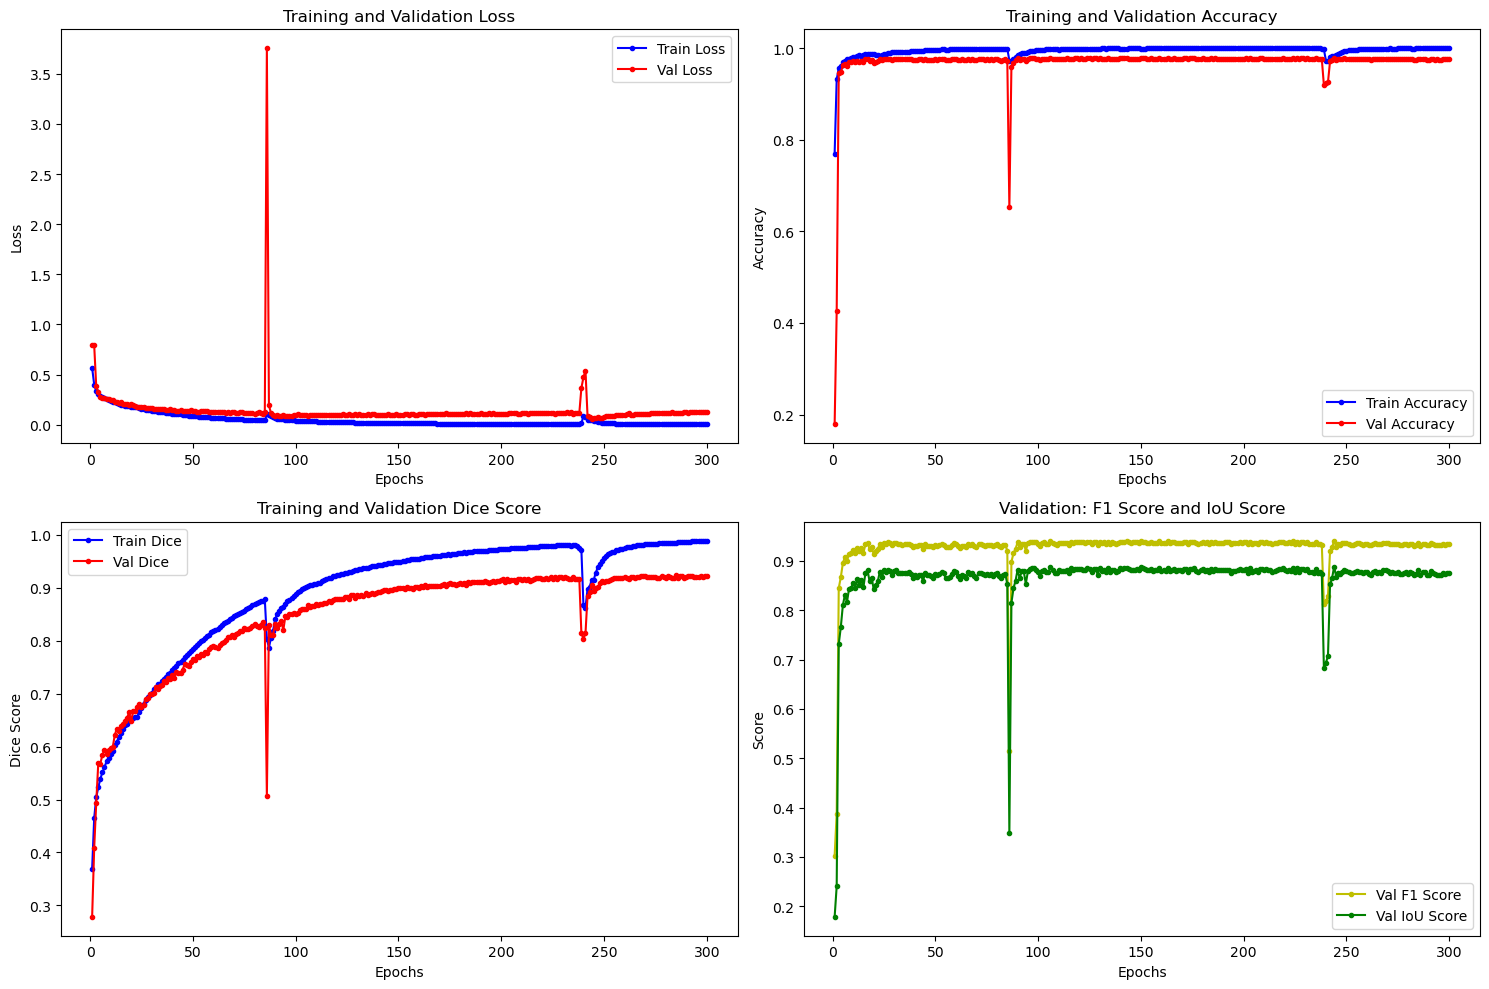

In [15]:
def plot_results(results):
    epochs = range(1, len(results['train_loss']) + 1)

    plt.figure(figsize=(15, 10))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, results['train_loss'], '.-b', label='Train Loss')
    plt.plot(epochs, results['val_loss'], '.-r', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, results['train_accuracy'], '.-b', label='Train Accuracy')
    plt.plot(epochs, results['val_accuracy'], '.-r', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Dice Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, results['train_dice'], '.-b', label='Train Dice')
    plt.plot(epochs, results['val_dice'], '.-r', label='Val Dice')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()

    # Plot F1-Score and IoU Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, results['val_f1'], '.-y', label='Val F1 Score')
    plt.plot(epochs, results['val_iou'], '.-g', label='Val IoU Score')
    plt.title('Validation: F1 Score and IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot results
plot_results(results) 

**Saving the Model** (already saved the best model in the training phase)

In [16]:
# # To save the Model with additional training data
# # UNet Model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'epoch': epoch,
#     'optimizer_state_dict': optimizer.state_dict(),
#     'results': results
# }, 'unet_kitti.ckpt')

# # Modified VGG Model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'epoch': epoch,
#     'optimizer_state_dict': optimizer.state_dict(),
#     'results': results
# }, 'modified_vgg_kitti.ckpt')

# To only save the Model
# torch.save(model.state_dict(), 'unet_kitti.pth')            # UNet Model 
# torch.save(model.state_dict(), 'modified_vgg_kitti.pth')    # Modified VGG Model

**Loading the Model**

In [17]:
# # Loading the UNET Model
# checkpoint = torch.load("/DML/Models/unet_kitti.ckpt")
# model.load_state_dict(checkpoint["model_state_dict"])

# # Loading the Modified VGG Model
# checkpoint = torch.load("/DML/Models/modified_vgg_kitti.ckpt")
# model.load_state_dict(checkpoint["model_state_dict"])

# Loading the Model
model.load_state_dict(torch.load('unet_kitti.pth'))
# model.load_state_dict(torch.load('/DML/Models/modified_vgg_kitti.pth'))

<All keys matched successfully>

**Evaluation on Test Set**

Final Loss: 0.0624 | F1-Score: 0.9281 | IoU: 0.8659 | Accuracy: 0.9779
Precision: 0.9306 | Recall: 0.9257 | ROC-AUC: 0.9961 | TSS: 0.9131


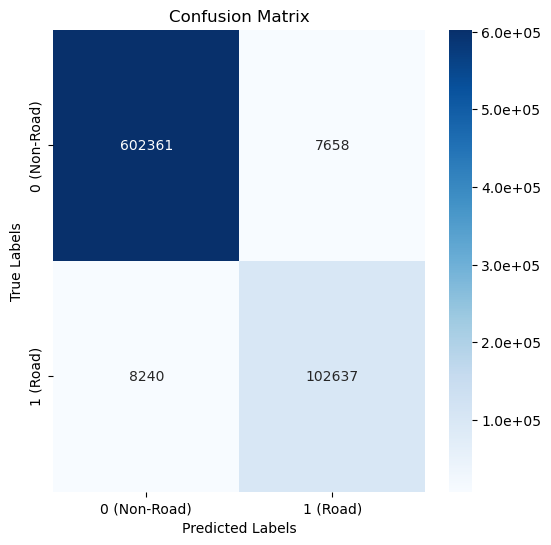

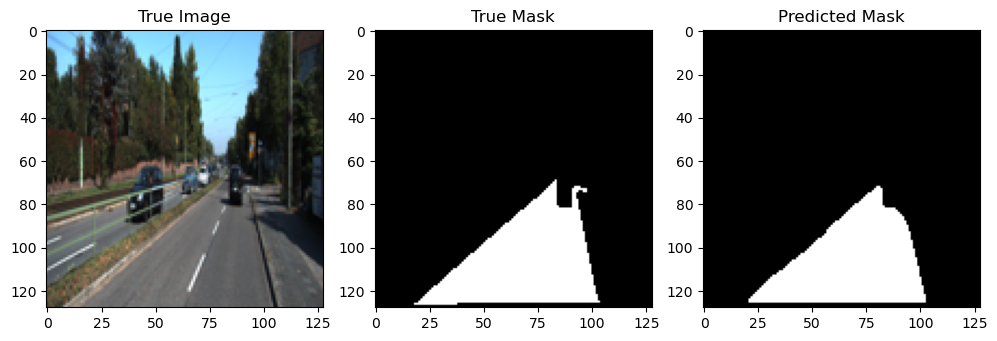

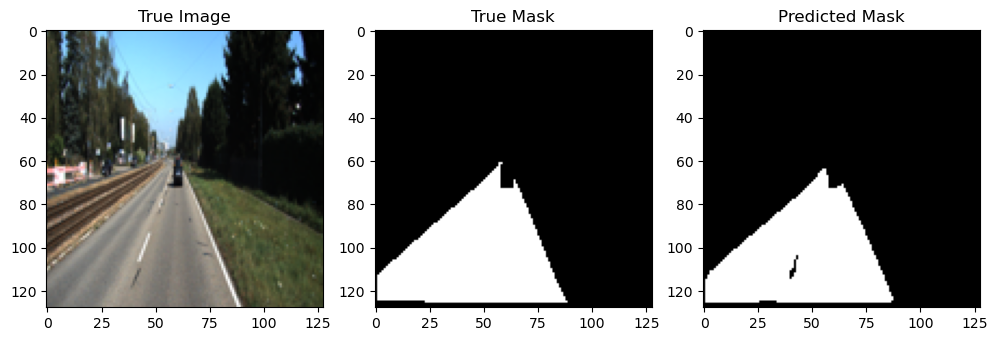

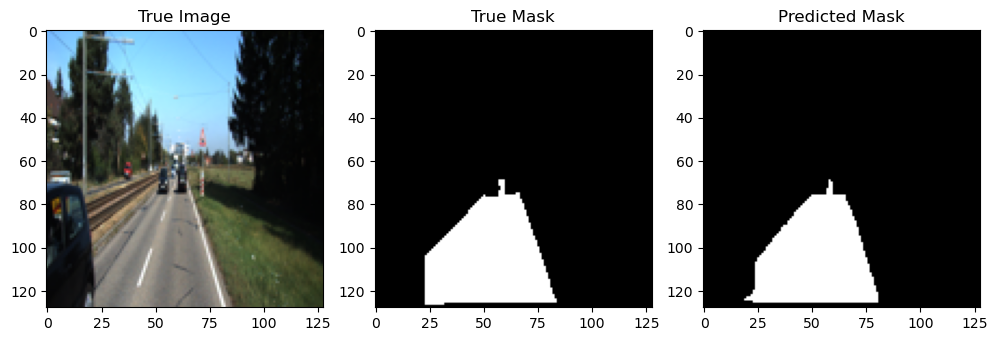

In [22]:
# EVALUATION PHASE
def evaluate_model(model, data_loader, loss_fn, device):
    
    # Evaluation Mode
    model.eval()
    
    # Initialize 
    all_true_masks = []
    all_pred_masks = []
    all_pred_probs = []  # For ROC-AUC calculation
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        # Loop through the DataLoader
        for test_input, test_mask in data_loader:

            # Set to device
            test_input, test_mask = test_input.to(device), test_mask.to(device)
            
            # Forward pass
            test_outputs = model(test_input.float())
            
            # Compute loss
            loss = loss_fn(test_outputs.float(), test_mask.float())
            total_loss += loss.item()
            num_batches += 1
            
            # Predictions
            predicted_masks = (test_outputs > 0.5).cpu().numpy()  # Set threshold to get binary masks
            predicted_probs = test_outputs.cpu().numpy()  # Keep original probabilities for ROC-AUC
            
            # True Masks
            true_masks = test_mask.cpu().numpy()

            # Appended all results into arrays (for entire DataLoader)
            all_pred_masks.append(predicted_masks)
            all_pred_probs.append(predicted_probs)  
            all_true_masks.append(true_masks)
    
    # Stack all masks to compute evaluation metrics
    all_pred_masks = np.vstack(all_pred_masks)
    all_true_masks = np.vstack(all_true_masks)
    all_pred_probs = np.vstack(all_pred_probs)
    
    # Average/Mean Loss
    avg_loss = total_loss / num_batches

    # Flatten the arrays (to compute evaluation metrics)
    flattened_pred_masks = all_pred_masks.flatten()
    flattened_true_masks = all_true_masks.flatten()
    flattened_pred_probs = all_pred_probs.flatten()  

    # Calculate evaluation metrics
    test_f1 = f1_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_iou = jaccard_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_accuracy = accuracy_score(flattened_true_masks, flattened_pred_masks)
    test_precision = precision_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_recall = recall_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_roc_auc = roc_auc_score(flattened_true_masks, flattened_pred_probs)

    # Calculate confusion matrix and TSS
    cm = confusion_matrix(flattened_true_masks, flattened_pred_masks)
    test_tss = calculate_tss(cm)  # Compute True Skill Score (TSS)

    return avg_loss, test_f1, test_iou, test_accuracy, test_precision, test_recall, test_roc_auc, test_tss, all_true_masks, all_pred_masks

# Plotting the Confusion Matrix
def plot_confusion_matrix(true_mask, pred_mask):
    cm = confusion_matrix(true_mask.flatten(), pred_mask.flatten())
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0 (Non-Road)", "1 (Road)"], yticklabels=["0 (Non-Road)", "1 (Road)"], cbar_kws={'format': '%.1e'})
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Calculating the TSS (True-Skill-Score) from confusion matrix
def calculate_tss(cm):
    TN, FP, FN, TP = cm.ravel()  # (2x2) confusion matrix (Binary Segmentation)
    TPR = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR = FP / (FP + TN)  # False Positive Rate
    TSS = TPR - FPR
    return TSS

# Plotting the Predicted Masks (alongside True Images and True Masks)
def visualize_predictions(X_test, Y_test, predicted_masks, test_idx):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # True Image
    ax[0].imshow(X_test[test_idx].transpose(1, 2, 0))
    ax[0].set_title("True Image")

    # True Mask
    ax[1].imshow(Y_test[test_idx].transpose(1, 2, 0), cmap='gray')
    ax[1].set_title("True Mask")

    # Predicted Mask
    ax[2].imshow(predicted_masks[test_idx].transpose(1, 2, 0), cmap='gray')
    ax[2].set_title("Predicted Mask")

    plt.tight_layout()
    plt.show()
    
# Evaluating the model on test dataset
(loss, test_f1, test_iou, test_accuracy, test_precision, 
 test_recall, test_roc_auc, test_tss, true_masks, pred_masks) = evaluate_model(model, test_dataloader, loss_fn, DEVICE)

# Printing the final evalutaion metrics
print(f"Final Loss: {loss:.4f} | F1-Score: {test_f1:.4f} | IoU: {test_iou:.4f} | Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | ROC-AUC: {test_roc_auc:.4f} | TSS: {test_tss:.4f}")

# Plot confusion matrix for all the test images
plot_confusion_matrix(np.vstack(true_masks), np.vstack(pred_masks))

# Adjust this index to visualize other test samples (test_idx <= len(test_dataloader))
test_idx_1 = 10  
test_idx_2 = 25
test_idx_3 = 35

# Visualize predictions
visualize_predictions(X_test, Y_test, pred_masks, test_idx_1)
visualize_predictions(X_test, Y_test, pred_masks, test_idx_2)
visualize_predictions(X_test, Y_test, pred_masks, test_idx_3)